# FeS Example Workflow 

This reproduces the initial example of fitting using athena and artemis as described by [Bruce Ravel](https://github.com/bruceravel/demeter/tree/master/examples/recipes/FeS2) published in notebook contains a modified version of the first task of the XAS processing workflow.  

The break up of the task consist of the following steps 

| Task                          | Input                                         | Output |
|:-------------|:-------------|:-----  |
|  1. Create Athena project      |                                               | |
|  1.1. Import data              |File: fes2_rt01_mar02.xmu                      | |
|  1.2. Normalisation            |Parameters: Pre-edge range = -117.00 to 30.000 | |
|  1.3. Save Athena Project        |                                               |File: FeS2_01.prj|
| 2. Curve fitting||
| 2.1. Open athena project                |File: FeS2_01.prj                              |
| 2.2. Import Crystal data        |File: FeS2.inp                                 |
| 2.3. Calculate Paths(Atoms+FEFF)||
| 2.4. Set path parameters        | Parameters:                                   |
|                                 |    amp  = 1                                   |
|                                 |    enot = 0                                   |
|                                 |    delr = 0                                   |
|                                 |    ss   = 0.003                               |
| 2.5. Select paths                 |                                               |
| 2.6. Run Fit                    |                                               |
| 2.7. Save project               ||
| 2.8. Verify fit results         ||
| 2.8.1 If not OK revise parameners and refit (go to 2.4)||
| 2.8.2 If OK Save project and outputs|                                           |File: FeS2_01.fpj


For more details about larch, see https://xraypy.github.io/xraylarch/xafs/


## Libraries
The next cell shows the libraries needed for performning task 1

In [1]:
# Library with the functions that rplicate those provided by athena
# normalisation, merging, re-binning, LCF
# and visualisation (plotting)
import lib.manage_athena as athenamgr  

# Library with the functions that execute 
# Atoms and FEFF to generate scattering paths
import lib.atoms_feff as feff_runner     

# Set parameters          
# library containign functions tho manage fit, at read, write 
# GDS parameters, and scattering paths. 
import lib.manage_fit as fit_manager  

# File handling
from pathlib import Path

#plotting library
%matplotlib inline
import matplotlib.pyplot as plt

#library for writing to log
import logging

## Custom Functions
The athenamgr library contains the functions (methods) for wrapping the larch functions required for processing XAS files.
- **set_logger** intialises the logging. 
- **get_files_list** returns a list of files in the directory matching the given file pattern.
- **fit_pre_post_edge** crates the pre-edge and postedge fits for mu.
- **plot_mu** shows the plot of mu in energy
- **plot_edge_fit** shows the plot of normalised data
- **plot_normalised** shows the plot of normalised data

## Input parameters (variables)
The variables in the next cell are the processing values that indicate where to get the data from, the pattern of the files to process and the number of files to process. These can be changed to process different datasets.

## Column and group names.

Knowing the elements of the input data set it is possible to start manipulating and visualising the XAFS data. 

In this case energy and $\mu$ are provided, but the names of the columns do not match the names used by Larch. 

We rename the columns. The name of the groups is the same as the name of the file. To make things easier we can also adjust the file name.


In [2]:
# variables that can be changed to process different datasets
data_path = "./"

file_name = "fes2_rt01_mar02.xmu"
f_prefix = "FeS2"
column_labels = "energy mu i0"

## 1. Create athena project
The code in the following cells peform the three sub-tasks of task 1. 

### 1.1 Import data 

- Use the athena manager to read the data in text form.
- Plot the data to show how it looks. 

[root] INFO : Started processing
[root] INFO : Processing: fes2_rt01_mar02.xmu
[root] INFO : Path: fes2_rt01_mar02.xmu


Log will be saved to: FeS2\process.log


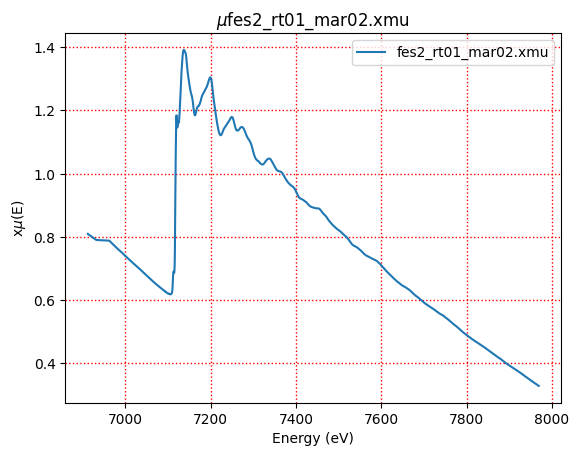

In [3]:
# start processing createa an output dir and sets the logger
source_path, out_path = athenamgr.files_setup(f_prefix, data_path)    

a_file =Path(source_path, file_name)

xas_data = {}

f_suffix = str(1).zfill(2) 
p_name = f_prefix+f_suffix
p_path = Path(out_path , p_name + ".prj")

# read the data into xas data
xas_data = athenamgr.read_text(a_file, column_labels)

# show the data that was read from the file
plt = athenamgr.plot_mu(xas_data)
plt.show()



### 1.2 Normalise

- fit pre and post edge and normalise setting pre-edge limits at -117 and 30 .
- Plot the data to show the results. 

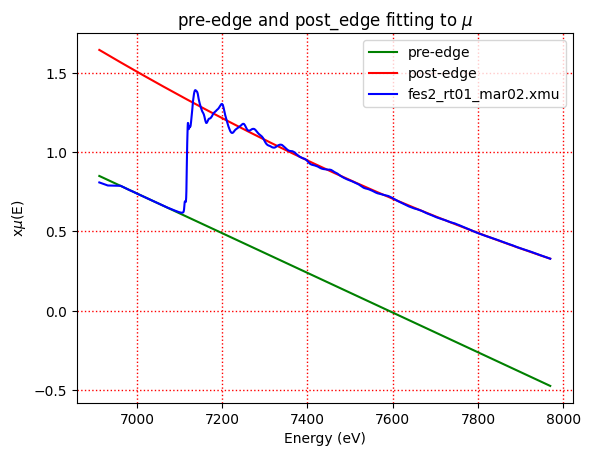

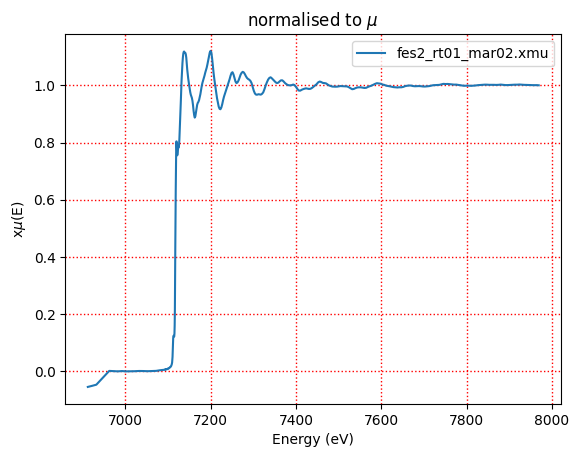

In [4]:
# calculate pre-edge and post edge 

xas_data = athenamgr.fit_pre_post_edge(xas_data, -117, 30)

# Show pre and post edge fit
plt = athenamgr.plot_edge_fit(xas_data)
plt.show()

# show normalised mu
plt = athenamgr.plot_normalised(xas_data)
plt.show()



### 1.3 Save athena project

In [5]:
# give a name to the project
xas_data.filename = p_name
athenamgr.save_athena(xas_data, p_path)
      
print("completed task one")

[root] INFO : project path: FeS2\FeS201.prj


completed task one


## 2. Curve Fitting


In [6]:
# variables that can be changed to process different datasets
# define the name of the input file
athena_file = p_path

# provide the crystal files as a list so more than one 
# be used in fitting
crystal_files = ["FeS2.inp"]# 

# GSD parameters and scattering paths are saved to csv files.
# provide the name of the gds file
gds_file = 'FeS2_gds.csv'
spl_file = 'FeS2_sp.csv'
# variables for fit
fit_vars = {}
fit_vars['fitspace']='r'
fit_vars['kmin']=3 
fit_vars['kmax']=14
fit_vars['kw']=2 
fit_vars['dk']=1
fit_vars['window']='hanning'
fit_vars['rmin']=1.4
fit_vars['rmax']=3.0

### 2.1 Open athena project
Open the just created project and show the data

['FeS201']


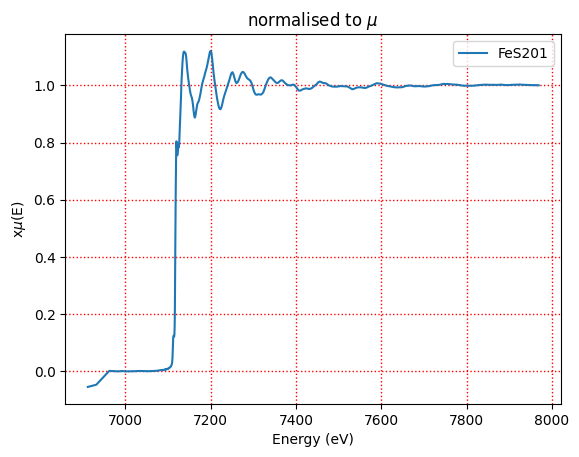

In [7]:
# read the input file 
athena_prj = athenamgr.read_project(athena_file)

athena_groups = athenamgr.get_groups(athena_prj)

group_names = []
for a_group in athena_groups:
    group_names.append(a_group.label)
    
print(group_names)
for a_group in athena_groups:
    athenamgr.calc_with_defaults(a_group)
    plt = athenamgr.plot_normalised(a_group)
    plt.show

### 2.2 Import Crystal data 
### 2.3 Run FEFF
For each crystal file in the crystal files list, the feff runer is executed to calculate the sets of diffraction paths 

In [8]:
# run feff and get a list of feff dirs
feff_dirs = feff_runner.run_feff(crystal_files)

inp
copying FeS2.inp  to  FeS2_feff\FeS2_feff.inp
 : ======== running Feff module C:\Users\scman1\AppData\Local\Programs\Python\Python39\lib\site-packages\larch\bin\win64\feff6l.exe ========
 : Feff 6L.02
 : name:     Iron sulfide (pyrite)
 : formula:  FeS_2
 : refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique potential    2
 : Preparing plane wave scattering amplitudes...
 : nncrit in prcrit       9
 : Searching for paths...
 : Rmax  6.0000  keep a

### 2.4 Set Parameters
The code for managing the parameters group (GDS in Artemis) is stored in lib/manage_gds.py. 

The following two cells show how the functions of manage_gds.py are used to read GDS parameters from a file, display the parameters and save them after they have been modified

The parameter values are the same used in [Bruce Ravel's example](https://github.com/bruceravel/demeter/tree/master/examples/recipes/FeS2).

In [10]:
from larch import Interpreter
logging.getLogger('matplotlib.font_manager').disabled = True
session = Interpreter()
# read save parameters from input gds file
gds = fit_manager.read_gds(gds_file, session)
# show gsd group parameters in a spreadsheet
this_sheet = fit_manager.show_gds(gds)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_file)

Sheet(cells=(Cell(column_start=0, row_end=18, row_start=0, squeeze_column=False, squeeze_row=False, value=[['i…

In [11]:
#read the gds data and save it to the csv file
gds = fit_manager.spreadsheet_to_gds(this_sheet, session)
# save gsd group parameters in a csv file
fit_manager.save_gds(gds, gds_file)

### 2.5 Select Paths
The selection of scattering paths aims at obtaining a list of paths to be used for the fit. For Larch the list must contain specially built *FeffPathGroup* objects. The creation of the path list has been separated in three stages: 
1. **Show feff paths** and allow selecting the ones to be used
2. Show selected paths **Assing parameters** and allow assigning parameters to them
3. **Create selected paths list** contating *FeffPathGroup* objects from larch

   The goal is to obtain a list of 
The first activity requires selecting paths from the FEFF directory. These paths are stored by feff in the files.dat

Each scattering path is loaded while setting the amplitude, $\Delta E_0$, $\Delta R$ and $\sigma^2$ parameters using the GDS parameters defined previously.

The groups are then added to a list of paths to be used for the fit.

#### 2.5.1 Show all FEFF paths

To select a path change the value of the select column to 1 in the table displayed after running the cell below.


In [12]:
path_sheet = fit_manager.show_feff_paths(crystal_files[0])#('FeS2.inp')
display(path_sheet)

[root] INFO : FeS2_feff path and FeS2_feff\files.dat found
[root] INFO : Reading from: FeS2_feff\files.dat
[root] INFO : 1: name:     Iron sulfide (pyrite)                        Feff 6L.02  potph 4.12
[root] INFO : 2: formula:  FeS_2
[root] INFO : 3: refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
[root] INFO : 4: Abs   Z=26 Rmt= 1.116 Rnm= 1.361 K shell
[root] INFO : 5: Pot 1 Z=26 Rmt= 1.121 Rnm= 1.372
[root] INFO : 6: Pot 2 Z=16 Rmt= 1.120 Rnm= 1.390
[root] INFO : 7: Gam_ch=1.325E+00 H-L exch
[root] INFO : 8: Mu=-4.281E+00 kf=2.108E+00 Vint=-2.122E+01 Rs_int= 1.720
[root] INFO : 9: -------------------------------------------------------------------------------
[root] INFO : headers:['file', 'sig2', 'amp_rati', 'deg', 'nlegs', 'r_effective']


Sheet(cells=(Cell(column_end=7, column_start=0, row_end=48, row_start=0, squeeze_column=False, squeeze_row=Fal…

#### 2.5.2 Assing parameters to paths

To define the parameters enter values like those presented in the table below into the spreadsheet that appears after running the code in the following cell. The values should correspond to those defined as GDS parameters previously.

|file                  |label | s02 |e0   |sigma2 |deltar      |
|----------------------|------|-----|-----|-------|------------|
|FeS2_feff/feff0001.dat|S1    |amp  |enot |ss     |alpha\*reff |
|FeS2_feff/feff0002.dat|S2    |amp  |enot |ss2    |alpha\*reff |
|FeS2_feff/feff0003.dat|S3    |amp  |enot |ss3    |alpha\*reff |
|FeS2_feff/feff0004.dat|Fe    |amp  |enot |ssfe   |alpha\*reff |


**Note:** Labelling is used for reference only using Artemis-FEFF given names. Larch's FEFF does not label paths.

In [13]:
sp_sheet = fit_manager.show_selected_paths(path_sheet)

Sheet(cells=(Cell(column_end=5, column_start=0, row_end=4, row_start=0, squeeze_column=False, squeeze_row=Fals…

In [14]:
fit_manager.save_selected_paths_list(sp_sheet, spl_file)
selected_paths = fit_manager.read_selected_paths_list(spl_file, session)

### 2.6 Run Fit

XAS fitting is performed in three steps:

1. Create a Transform group to hold the set of Fourier transform parameters, fitting ranges, and space in which the data and sum of paths are to be compared (R space)
2. Create a Dataset group,consistaining of the three components required for fitting(data, paths, and transform group)
3. FEFFIT is run with the list of parameters (gds) for the fit, and the dataset or list of datasets groups.



In [15]:
# run fit
trans, dset, out = fit_manager.run_fit(athena_groups[0], gds, selected_paths, fit_vars, session)

### 2.7 Review fit results

The results of the fit are stored in the dataset. These can be plotted and printed as follows.

- The first view is the overlaped $\chi(k)$ and $\chi(R)$ plots (similar to Demeter's Rmr plot)
- The second view presents separate $\chi(k)$ and $\chi(R)$ plots 

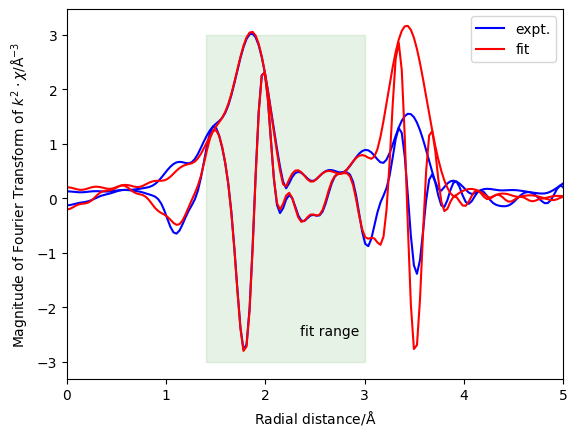

In [16]:
rmr_p = fit_manager.plot_rmr(dset,fit_vars['rmin'],fit_vars['rmax'])
rmr_p.show()

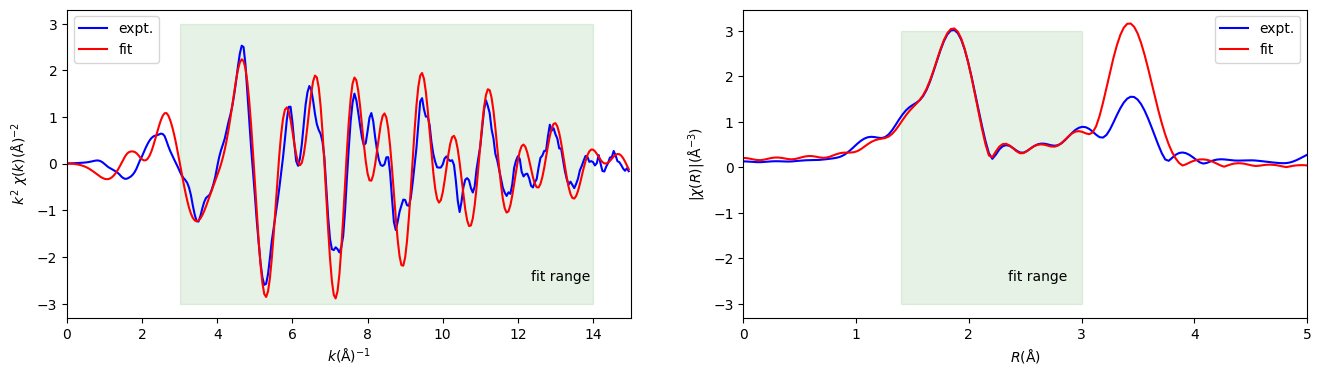

In [17]:
chikr_p = fit_manager.plot_chikr(dset,fit_vars['rmin'],fit_vars['rmax'],fit_vars['kmin'],fit_vars['kmax'])
chikr_p.show()

In [20]:
fit_report = fit_manager.get_fit_report(out, session)

print(fit_report)

#save the fit report to a text file
fit_manager.save_fit_report(out, "FeS2_fit_rep.txt", session)


=================== FEFFIT RESULTS ====================
[[Statistics]]
   nvarys, npts       =  8, 104
   n_independent      =  12.205
   chi_square         =  175.160893
   reduced chi_square =  41.6602593
   r-factor           =  0.00138607
   Akaike info crit   =  48.5115834
   Bayesian info crit =  52.5260265
 
[[Data]]
   fit space          = 'r'
   r-range            = 1.400, 3.000
   k-range            = 3.000, 14.000
   k window, dk       = 'hanning', 1.000
   paths used in fit  = ['FeS2_feff/feff0001.dat', 'FeS2_feff/feff0002.dat', 'FeS2_feff/feff0003.dat', 'FeS2_feff/feff0004.dat']
   k-weight           = 2
   epsilon_k          = Array(mean=5.0151e-04, std=4.6023e-04)
   epsilon_r          = 0.01037290
   n_independent      = 12.205
 
[[Variables]]
   alpha          =  5.3211e-05 +/-unknown   (init=  0.00000000)
   amp            =  0.73539439 +/-unknown   (init=  1.00000000)
   delr           =  0.00000000 +/-unknown   (init=  0.00000000)
   enot           =  2.68380437 +/-